[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bradley-Buchner/milieu_worm/blob/master/notebooks/milieu_worm_walkthrough.ipynb)

# *Mutual Interactors* for discovering aging-related proteins in *C. elegans*

**Author:** Bradley Buchner

This notebook includes an implementation of the network-based machine learning framework known as *Mutual Interactors*, developed by Eyoboglu et al. (2023), that extends it to characterize genes/proteins and their association with aging in the roundworm *C. elegans*. For a more detailed description of how the method works, please see their paper: https://pubmed.ncbi.nlm.nih.gov/36540965/

Run the code in each cell below to train a *Mutual Interactors* model on the *C. elegans* genetic interaction network, predict novel aging genes/proteins, and derive mutual interactor significance scores for every gene/protein in the network.


In [ ]:
# --- Clone the milieu_worm repository ---
!git clone https://github.com/Bradley-Buchner/milieu_worm.git

In [ ]:
# --- Install required packages ---
!pip install -r milieu_worm/requirements.txt
%load_ext google.colab.data_table

In [1]:
# --- Change working directory to '/content/milieu_worm' ---
import os

# print(f"Current wd: {os.getcwd()}")
# os.chdir('milieu_worm')
# print(f"Updated wd: {os.getcwd()}")

parent_dir = os.path.dirname(os.getcwd())
os.chdir(parent_dir)
print(f"Updated wd: {os.getcwd()}")

Updated wd: /Users/bradleybuchner/Desktop/grad_school/research/aging_project/milieu


In [2]:
# --- Import calls ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
import pickle

from milieu.data.network import Network
from milieu.milieu import MilieuDatasetWorm, MilieuWorm
from milieu.data.associations import load_biological_processes

In [3]:
# --- Switch over to gpu if available ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Computation device: {device}")

Computation device: mps


### Load network and association data
This section initializes the file paths and loads the *C. elegans* genetic interaction network and biological process associations into memory. The network is stored as a Network object, which manages the adjacency matrix used by the model's learning algorithm.

In [4]:
# --- Define file paths ---
wd = os.getcwd()
path_to_worm_data = os.path.join(wd, "data")
path_to_worm_network = os.path.join(path_to_worm_data, "networks/species_6239/wormbase")
path_to_worm_associations = os.path.join(path_to_worm_data, "associations/wormbase")

In [5]:
# --- Build the network using the adjacency list file path ---
adj_list_path = os.path.join(path_to_worm_network, "worm_network_basic_full_adjacency.txt")
full_network = Network(adj_list_path)
print(full_network.nx)

Graph with 11513 nodes and 84667 edges


In [6]:
# --- Load biological process association data ---
associations_file_path = os.path.join(path_to_worm_associations, 'biological_process_associations.csv')
bp_associations = pd.read_csv(associations_file_path)
display(bp_associations.head())

print(f"Number of biological processes: {bp_associations.shape[0]}")

,biological_process_id,biological_process_name,associated_gene_wb_ids,count,splits
0,GO:0000002,mitochondrial genome maintenance,"WBGene00004028,WBGene00011662,WBGene00019800,W...",4,none
1,GO:0000014,single-stranded DNA endodeoxyribonuclease acti...,"WBGene00000787,WBGene00001016,WBGene00003405,W...",4,none
2,GO:0000022,mitotic spindle elongation,"WBGene00002994,WBGene00006381",2,none
3,GO:0000027,ribosomal large subunit assembly,"WBGene00004416,WBGene00007617,WBGene00012692,W...",6,none
4,GO:0000028,ribosomal small subunit assembly,"WBGene00004469,WBGene00004474,WBGene00004483,W...",11,none


Number of biological processes: 4067


In [7]:
# --- Subset biological processes with at least 10 associated genes ---
bp_subset = []
for row in bp_associations.itertuples(index=False):
    if not row.count < 10:
        bp_subset.append(row.biological_process_id)

# Print the number of retained biological processes and total processes
print(f"Number of biological processes with 10 or more associated genes: {len(bp_subset)}")

Number of biological processes with 10 or more associated genes: 694


### Extract node sets and create training/validation split
Here, we filter out biological processes with insufficient data and convert them into NodeSet objects to be used as training examples. These sets are then split into training and validation datasets and wrapped in MilieuDatasetWorm objects, which handle the random sampling of phenotype associations for the input and target sets to simulate node set expansion.

In [8]:
# --- Split biological processes into training and validation sets ---
random.seed(24)
train_prop = 0.8

# Load NodeSet objects (filtered by bp_subset) from the CSV
node_sets = list(load_biological_processes(associations_file_path, biological_process_subset=bp_subset).values())
random.shuffle(node_sets)
split = int(len(node_sets)*train_prop)
train_node_sets = node_sets[:split]
valid_node_sets = node_sets[split:]

# --- Create MilieuDatasetWorm objects ---
train_dataset = MilieuDatasetWorm(full_network, node_sets=train_node_sets)
valid_dataset = MilieuDatasetWorm(full_network, node_sets=valid_node_sets)
full_dataset = MilieuDatasetWorm(full_network, node_sets=node_sets)

### Define model parameters
In this section we configure the hyperparameters for the model, including `edge_dropout_alpha`, which represents the lower bound or "floor" for edge dropout probability. We also defines `metric_configs`, a list of dictionaries that specify which evaluation functions and arguments—such as recall-at-25—the model should use to compute performance metrics during training.

In [9]:
# --- Define training and model parameters ---
params = {
    "mps": True,
    "device": device,
    "seed": 24,
    "batch_size": 32,
    "num_workers": 0,
    "num_epochs": 80,
    "early_stopping_patience": 500, # to not use early stopping, set value greater than num_epochs
    "edge_dropout_alpha": 0.5, # edge dropout probability floor

    "optim_class": "Adam",
    "optim_args": {
        "lr": 0.01,
        "weight_decay": 0.0
    },

    "metric_configs": [
        {
            "name": "recall_at_25",
            "fn": "batch_recall_at",
            "args": {"k":25}
        }
    ]
}

## Build and train a MilieuWorm model
Using the pre-defined parameters and loaded interaction network, here we initialize, compile, and train a MilieuWorm instance on the biological processes datasets. The training process optimizes the "mutual interactor weights" which represent the global significance of each gene as a mutual interactor.

In [10]:
# --- Initialize and compile the model ---
milieu_worm = torch.compile(MilieuWorm(full_network, params))

Milieu
Setting parameters...
Building model...
Building optimizer...
Done.


In [12]:
# --- Train the model ---
# Make sure to change runtime type to GPU if available
train_metrics, valid_metrics, train_losses, valid_losses = milieu_worm.train_model(train_dataset, valid_dataset)

Training Progress: 100%|██████████| 80/80 [01:41<00:00,  1.27s/it, loss=1.0423, val_loss=1.0272]


### Summarize MilieuWorm training
In this section we take a quantitative look at the model's performance by printing the minimum validation loss and maximum average recall-at-25. We also generate a plot of the training and validation loss curves to help visualize the model's convergence and check for overfitting.

In [13]:
# --- Print training and validation metrics ---
print("=== MilieuWorm Training Summary ===\n")
print(f"Min validation loss: {np.min(valid_losses):.3f}")
valid_recalls = [epoch["recall_at_25"] for epoch in valid_metrics]
avg_valid_recalls = [np.mean(epoch["recall_at_25"]) for epoch in valid_metrics]

print(f"Max avg validation recall-at-25: {np.max(avg_valid_recalls):.3f}")

=== MilieuWorm Training Summary ===

Min validation loss: 1.007
Max avg validation recall-at-25: 0.285


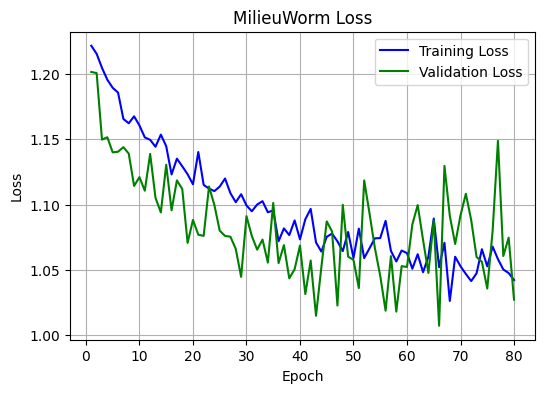

In [14]:
# --- Plot the training and validation loss ---
epochs = range(1, len(valid_losses)+1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, valid_losses, 'g', label='Validation Loss')
plt.title('MilieuWorm Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Train MilieuWorm using 10-fold cross-validation
Here we execute 10-fold cross-validation to ensure the model's predictive power is robust and generalizable across different biological processes. This provides a more reliable estimate of the average recall-at-25 score.

In [15]:
# --- Define cross-validation function ---
def run_cross_validation(full_network, node_sets, params, n_splits=10, random_seed=23):
    """
    Performs k-fold cross-validation for the Milieu model.

    Parameters:
    -----------
    full_network (Network): The full gene regulatory network.
    node_sets (list): List of node-sets.
    params (dict): Model and training hyperparameters.
    n_splits (int): Number of folds for cross-validation.
    random_seed (int): Seed for reproducibility.

    Returns:
    --------
    cv_summary (dict): Summary metrics for the cross-validation run..
    """
    import logging
    from copy import deepcopy
    from sklearn.model_selection import KFold
    import time

    # Start timer
    start_time = time.perf_counter()
    logging.info(f"Starting {n_splits}-fold cross-validation.")
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    train_fold_metrics = []
    val_fold_metrics = []
    train_fold_losses = []
    val_fold_losses = []

    frac_known = params.get("frac_known", 0.9)
    use_mps = params.get("mps", False)
    device = params.get("device", "cpu")
    metric_name = params.get("metric_configs")[0]["name"]
    num_epochs = params.get("num_epochs")

    train_val_split = kf.split(node_sets)

    for fold, (train_idx, val_idx) in enumerate(train_val_split):
        logging.info(f"--- Fold {fold + 1}/{n_splits} ---")

        train_node_sets = [node_sets[i] for i in train_idx]
        valid_node_sets = [node_sets[i] for i in val_idx]

        train_set = MilieuDatasetWorm(full_network, node_sets=train_node_sets,
                                      frac_known=frac_known)

        val_set = MilieuDatasetWorm(full_network, node_sets=valid_node_sets,
                                    frac_known=frac_known)

        model = MilieuWorm(full_network, deepcopy(params), edge_dropout=False)
        if use_mps:
            model.to(device)
        model._build_optimizer()

        train_metrics, val_metrics, train_losses, val_losses = model.train_model(train_set, val_set)
        del model
        torch.mps.empty_cache()

        train_fold_metrics.append(train_metrics)
        val_fold_metrics.append(val_metrics)
        train_fold_losses.append(train_losses)
        val_fold_losses.append(val_losses)

    cv_val_metrics = {}
    for fold, fold_results in enumerate(val_fold_metrics):
        cv_val_metrics[f"fold_{fold + 1}"] = [np.mean(epoch_result.get(metric_name)) for epoch_result in fold_results]

    cv_val_losses = {f"fold_{fold + 1}": fold_results for fold, fold_results in enumerate(val_fold_losses)}

    best_fold_metric_val = []
    for fold, metrics in cv_val_metrics.items():
        best_fold_metric_val.append(np.max(metrics))

    best_fold_loss_val = []
    for fold, losses in cv_val_losses.items():
        best_fold_loss_val.append(np.min(losses))

    avg_val_metrics = []
    for epoch in range(num_epochs):
        epoch_results = [vals[epoch] for fold, vals in enumerate(cv_val_metrics.values())]
        avg_val_metrics.append(np.mean(epoch_results))

    avg_val_losses = []
    for epoch in range(num_epochs):
        epoch_results = [vals[epoch] for fold, vals in enumerate(cv_val_losses.values())]
        avg_val_losses.append(np.mean(epoch_results))

    # Stop timer
    elapsed = time.perf_counter() - start_time
    mins, secs = divmod(elapsed, 60)
    elapsed_str = f"{int(mins)} minute{'s' if mins!=1 else ''} and {secs:.2f} seconds"
    logging.info(f"Cross-validation completed in {elapsed_str}.")

    cv_summary = {
        "elapsed_time_sec": elapsed,
        "elapsed_time_str": elapsed_str,
        "best_metric_folds_val_cv": best_fold_metric_val,
        "best_loss_folds_val_cv": best_fold_loss_val,
        "val_loss_epochs_cv": avg_val_losses,
        "val_metric_epochs_cv": avg_val_metrics,
        "avg_best_metric_val": np.mean(best_fold_metric_val),
        "avg_best_loss_val": np.mean(best_fold_loss_val)
    }

    return cv_summary

In [ ]:
# --- Run cross-validation ---
# Takes about 30 minutes, so if you'd rather skip this step simply load in the pre-run cross-validation results in the next cell. Otherwise, uncomment and run this cell's code.

# cv_result_summary = run_cross_validation(full_network, node_sets, params, n_splits=10, random_seed=23)

# # --- Save to pickle (if necessary) ---
# with open(os.path.join(path_to_worm_network, "milieu_cv_results.pkl"), "wb") as f:
#     pickle.dump(cv_result_summary, f)

In [16]:
# --- Load results if CV has already been run and results have been saved ---
with open(os.path.join(path_to_worm_network, "milieu_cv_results.pkl"), "rb") as f:
    cv_result_summary = pickle.load(f)

In [17]:
# --- Print CV results ---
print("=== 10-fold CV Results ===\n")
print(f"Avg best validation recall-at-25: {cv_result_summary.get('avg_best_metric_val'):.3f}")
print(f"Avg best validation loss: {cv_result_summary.get('avg_best_loss_val'):.3f}")

=== 10-fold CV Results ===

Avg best validation recall-at-25: 0.301
Avg best validation loss: 1.019


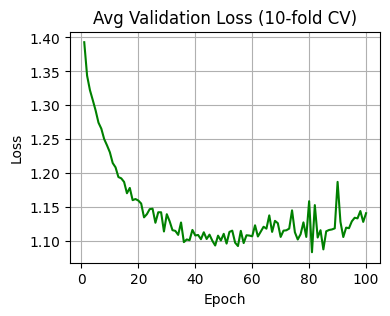

In [18]:
# --- Plot the avg CV training and validation loss ---
val_losses_n = cv_result_summary['val_loss_epochs_cv']
epochs = range(1, len(val_losses_n)+1)

plt.figure(figsize=(4, 3))
plt.plot(epochs, val_losses_n, 'g')
plt.title('Avg Validation Loss (10-fold CV)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

### Test the significance of 10-fold CV validation recall-at-25
To determine if the model's performance is better than random, we compare the actual recall-at-25 scores against a null distribution generated from a randomized model. By calculating an empirical p-value, we can statistically confirm that the MilieuWorm model is learning biologically meaningful features.

In [19]:
# --- Load a distribution of null recall-at-25 values generated from a randomized model ---
val_metric_null_dist = np.load(os.path.join(path_to_worm_network, "val_metric_null_dist.npy"))

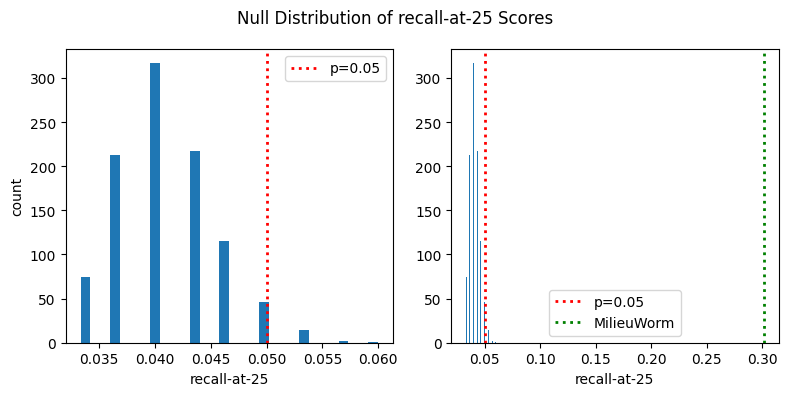


=== Significance of 10-fold CV Results: ===

recall-at-25: 0.30111	 p-value: 0.0010 ***


In [20]:
# --- Plot the null distribution of recall-at-25 scores ---
p95 = np.percentile(val_metric_null_dist, 95)

actual_n = cv_result_summary['avg_best_metric_val']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].hist(val_metric_null_dist, bins=30)
axes[0].axvline(p95, color='red', linestyle=':', linewidth=2, label=f'p=0.05')
axes[1].hist(val_metric_null_dist, bins=30)
axes[1].axvline(p95, color='red', linestyle=':', linewidth=2, label=f'p=0.05')
axes[1].axvline(actual_n, color='g', linestyle=':', linewidth=2, label=f'MilieuWorm')
axes[0].set_xlabel("recall-at-25")
axes[0].set_ylabel("count")
axes[1].set_xlabel("recall-at-25")
axes[0].legend()
axes[1].legend()
fig.suptitle("Null Distribution of recall-at-25 Scores")
plt.tight_layout()
plt.show()

p_val_n = (np.sum(np.array(val_metric_null_dist) >= actual_n) + 1) / (len(val_metric_null_dist) + 1)

print("\n=== Significance of 10-fold CV Results: ===")
print(f"\nrecall-at-25: {actual_n:.5f}\t p-value: {p_val_n:.4f} ***")

### Build and train MilieuWorm on all node sets (training + validation)
Observing that validation loss tends to plateau around 50 epochs during cross-validation, we retrain the model for 50 epochs on the entire collection of biological processes to create a "final" version with the maximum possible information. This finalized model is used for the ultimate prediction of novel aging genes and the subsequent calculation of significance scores.

In [21]:
# --- Train on all nodes sets (training + validation) ---
from copy import deepcopy
params_full = deepcopy(params)
params_full["num_epochs"] = 50
milieu_worm_full = MilieuWorm(full_network, params_full)
train_metrics_full, train_losses_full = milieu_worm_full.train_model(full_dataset)

Milieu
Setting parameters...
Building model...
Building optimizer...
Done.


Training Progress: 100%|██████████| 50/50 [01:08<00:00,  1.38s/it, loss=1.0679]


## Predict aging associations with the final model
Here we use the trained final model to perform node-set expansion on the "determination of adult lifespan" phenotype. It outputs the top $k$ genes with the highest probability of being associated with this phenotype that were not already in the original seed set.

In [22]:
# --- Extract aging-associated genes ---
aging_associations_str = list(bp_associations[bp_associations["biological_process_name"] == "determination of adult lifespan"]["associated_gene_wb_ids"])[0]
aging_wbid_list = [s.strip() for s in aging_associations_str.split(",")]
print(f"Number of aging-associated genes: {len(aging_wbid_list)}")

Number of aging-associated genes: 262


In [23]:
# --- Predict novel aging proteins with the final trained model ---
k = 10
preds = milieu_worm_full.expand(node_names=aging_wbid_list, top_k=k)

print("=== Final Model Predictions ===\n")
print(f"Top {k} nodes with highest probability of aging association\n")
for i, (name, pred) in enumerate(preds):
    print(f"{i+1}. '{name}' (Prob.: {pred:.7f})")


=== Final Model Predictions ===

Top 10 nodes with highest probability of aging association

1. 'WBGene00004014' (Prob.: 1.0000000)
2. 'WBGene00002162' (Prob.: 1.0000000)
3. 'WBGene00006526' (Prob.: 1.0000000)
4. 'WBGene00004799' (Prob.: 1.0000000)
5. 'WBGene00305568' (Prob.: 1.0000000)
6. 'WBGene00004930' (Prob.: 1.0000000)
7. 'WBGene00006070' (Prob.: 1.0000000)
8. 'WBGene00004015' (Prob.: 1.0000000)
9. 'WBGene00201678' (Prob.: 1.0000000)
10. 'WBGene00199318' (Prob.: 1.0000000)


## Quantify aging-specific mutual interactor significance
In this section, we implement a function to derive an "Aging-Specific Bridge" importance score by combining a gene's learned global weight with its connectivity to known aging genes. This metric identifies genes that act as critical functional links specifically within the aging genetic interaction network.

Based on the prediction equation of a *Mutual Interactors* model, the contribution of any mutual interactor $z$ is determined by its learned weight ($w_z$) normalized by its degree ($d_z$). Therefore, the importance of gene $z$ to any phenotype $\tilde{S}$ is:$$\text{PhenotypeImportance}(z) = \underbrace{| N(z) \cap \tilde{S} |}_{\text{Connections to Phenotype Genes}} \times \underbrace{\frac{w_z}{\sqrt{d_z}}}_{\text{Global Quality}}$$

Where...
* $| N(z) \cap \tilde{S} |$: The number of known phenotype-associated proteins that directly interact with gene $z$. This measures how much "traffic" from the phenotype-specific network flows through this bridge.
* $w_z$: The learned parameter indicating how reliable gene $z$ is as a mutual interactor in general (learned during training).
* $\sqrt{d_z}$: The degree normalization factor. The model penalizes high-degree "hub" proteins unless they have a very high learned weight, preferring specific, lower-degree bridges.

We also display a summary dataframe where each row corresponds to a gene and the columns are defined as follows:
* `gene_id`: unique WormBase gene identifier
* `global_weight_wz`: mutual interactor weight learned by the model
* `normalized_weight`: mutual interactor weight normalized by the square root of its degree
* `phenotype_connections`: number of connections to genes in the node-set of the specified phenotype (e.g., aging)
* `phenotype_importance_score`: measure of phenotype-specific significance as a mutual interactor

In [24]:
# --- Define function to compute aging-specific mutual interactor importance ---
def get_phenotype_mi_significance(milieu_worm, network, seed_node_names):
    """
    Calculates the 'Phenotype-Specific Bridge' importance for all genes in the interaction
    network using a pre-trained MilieuWorm instance.

    This metric quantifies a node's influence as a mutual interactor for a specific phenotype
    by combining its model-learned global weight with its connectivity to the phenotype's
    seed genes. The model penalizes high-degree 'hub' proteins unless
    they have a very high learned weight, preferring specific, lower-degree bridges.

    Parameters:
    -----------
    milieu_worm (MilieuWorm): A trained MilieuWorm model containing the optimized 'milieu_weights' (w_z)
        representing the global reliability of genes as mutual interactors.
    network (Network): The interaction network object containing the mapping of gene names to nodes
        and the interactome structure.
    seed_node_names (list): A list of gene identifiers (e.g., WormBase IDs) representing the seed set
        for the phenotype of interest (e.g., aging-associated genes).

    Returns:
    --------
    results (DataFrame): A DataFrame sorted by 'phenotype_importance_score' in descending order.
        Columns include:
        - 'gene_id': Unique identifier for the gene.
        - 'global_weight_wz': The raw milieu weight learned during training.
        - 'normalized_weight': The weight normalized by the square root of the node degree.
        - 'phenotype_connections': Number of direct interactors in the phenotype seed set.
        - 'phenotype_importance_score': The final significance score derived from weighted
          phenotype connectivity.
    """
    # Set model to evaluation mode
    model = milieu_worm
    model.eval()

    # Extract gene names from the network
    gene_names = list(network.name_to_node.keys())

    # Use the adjacency matrix stored in the model to ensure alignment with weights
    adj_matrix = model.adj_matrix_tensor
    device = adj_matrix.device

    # Extract learned global weights (w_z)
    with torch.no_grad():
        w_z = model.milieu_weights.data.cpu().numpy().flatten()

        # Calculate degrees from the adjacency matrix and get normalized w_z
        degrees = adj_matrix.sum(dim=1).cpu().numpy()
        normalized_wz = w_z / np.sqrt(degrees + 1e-9)

    # Establish the phenotype seed set (S_tilde) with a mask
    phenotype_mask = np.isin(gene_names, seed_node_names).astype(float)
    phenotype_seeds = torch.from_numpy(phenotype_mask).float().to(device)

    # Calculate how many 'aging' neighbors each node has, if seed nodes are aging-related
    phenotype_connectivity = torch.matmul(adj_matrix, phenotype_seeds.unsqueeze(1)).squeeze().cpu().numpy()

    # Compute the final importance score (weighted phenotype connectivity)
    phenotype_importance_scores = phenotype_connectivity * normalized_wz

    results = pd.DataFrame({
        'gene_id': gene_names,
        'global_weight_wz': w_z,
        'normalized_weight': normalized_wz,
        'phenotype_connections': phenotype_connectivity,
        'phenotype_importance_score': phenotype_importance_scores
    })

    return results.sort_values(by='phenotype_importance_score', ascending=False)

In [26]:
# --- Compute and display a summary dataframe ---
mi_score_summary = get_phenotype_mi_significance(
    milieu_worm=milieu_worm_full,
    network=full_network,
    seed_node_names=aging_wbid_list
)

print("=== Mutual Interactor Significance Summary ===\n")
display(mi_score_summary)

=== Mutual Interactor Significance Summary ===



,gene_id,global_weight_wz,normalized_weight,phenotype_connections,phenotype_importance_score
8345,WBGene00010340,3.883430,1.373000,8.0,10.983999
2914,WBGene00001133,3.897692,0.465863,23.0,10.714855
1366,WBGene00000903,6.194720,0.762517,14.0,10.675241
4077,WBGene00006526,5.001990,0.771824,13.0,10.033710
10365,WBGene00000910,4.683387,0.855066,11.0,9.405722
...,...,...,...,...,...
3261,WBGene00004741,-9.398453,-9.398453,1.0,-9.398453
6287,WBGene00004734,-9.398453,-9.398453,1.0,-9.398453
7063,WBGene00001846,-9.398453,-9.398453,1.0,-9.398453
9476,WBGene00004731,-9.398453,-9.398453,1.0,-9.398453


Rather than simply using a *Mutual Interactors* model to make predictions of gene-phenotype associations, we can design a metric like `phenotype_importance_score` to characterize genes differently and identify functional links that are critical to a phenotype's interaction network. By uncovering these significant linker genes, we can move beyond treating gene-phenotype associations as isolated events and instead measure gene influence in a way that is grounded in the biological principle of mutual interactors.